In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = mne.datasets.eegbci.load_data(3,1)
path[0]

[............................................................] 100.00% (  1.2 MB,   771 kB/s) \


'/home/parv/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf'

In [5]:
raw = mne.io.read_raw_edf(path[0], preload = True)

Extracting EDF parameters from /home/parv/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of ticklabels (1).

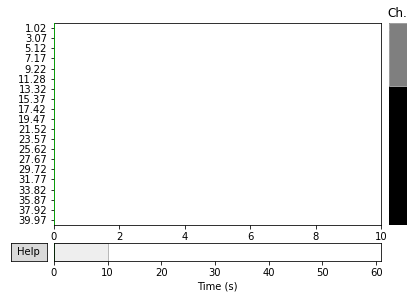

In [6]:
raw.plot(scalings = 'auto')

In [ ]:
ch_names = ['A', 'B']
sfreq = 200 #Sampling Frequency 
info = mne.create_info(ch_names, sfreq)
info

In [ ]:
samples = np.array([[-1, 0, -1, 1, 1], [0, 1, 0, -1, 0]]) # Samples for each channel
loadedRaw = mne.io.RawArray(samples, info)
#So it seems like we are visulaising samples from our data? 

In [ ]:
loadedRaw.plot(scalings = 'auto')

In [ ]:
# Power spectral density plot - Power Spectral Density (PSD) is a frequency-domain plot of power per Hz vs frequency. Averaging the periodograms of segments of long-duration signals more accurately assigns the power to the correct frequencies and averages to reduce noise-induced fluctuations in the power amplitudes.
raw.plot_psd(tmin = 0, tmax = 60, fmin = 1, fmax = 80, average = True, spatial_colors = False)

Now that we have raw data, we can select the frequencies we are interested in. Firstly, we want to remove the 60 hz power line noise. 

In [7]:
raw.notch_filter(60)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 sec)



<RawEDF  |  S003R01.edf, n_channels x n_times : 64 x 9760 (61.0 sec), ~4.9 MB, data loaded>

In [8]:
# Removing very high or low frequcies that may not be useful to us 
raw.filter(l_freq = 1, h_freq = 60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 529 samples (3.306 sec)



<RawEDF  |  S003R01.edf, n_channels x n_times : 64 x 9760 (61.0 sec), ~4.9 MB, data loaded>

Effective window size : 12.800 (s)


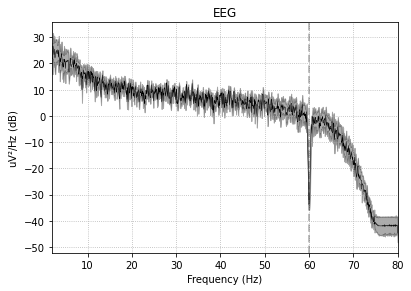

In [9]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

We can now downsample the data - downsampling is when you're working with a large dataset and facing memory limits on your computer or simply want to reduce processing time.

Effective window size : 17.067 (s)


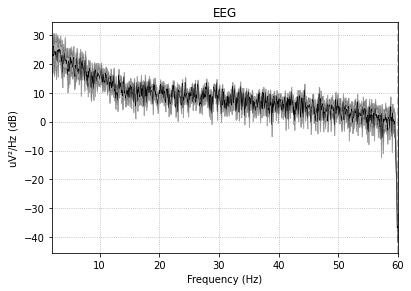

In [10]:
# Downsample a lot
raw.resample(120, npad = 'auto')
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=True, spatial_colors=False);

Looking for bad channels in the raw data

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of ticklabels (1).

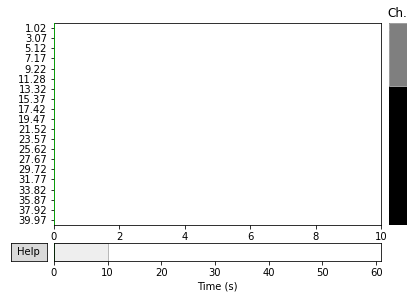

In [11]:
raw.plot(scalings = 'auto')

C4 looks significantly noisier than the others, let's flag it as a bad channel

In [16]:
raw.info['bads'] += ['C4..']
picks = mne.pick_types(raw.info, exclude = 'bads')

RuntimeError: bad channel(s) ['C4..'] marked do not exist in info

Now that we have removed a channel, we can interpolate the data coming from that channel via spherical spline interpolation.

In order to be able to do that, we need to make sure that our channels have location information:

In [13]:
print(raw.info['chs'])

RecursionError: maximum recursion depth exceeded while calling a Python object

We notice here that the data has no location attributes , loc = [0,0...0] - but we can assume that it was conducted using a general theme, so we can load a pre configured channel file and use that instead.

In [15]:
montage = mne.channels.read_montage('standard_1020')
raw.rename_channels(mapping= lambda name: name.replace(".",""))
raw.set_montage(montage)

/home/parv/Documents/Brain/NeuralData/data/lib/python3.8/site-packages/mne/utils/docs.py:824: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/home/parv/Documents/Brain/NeuralData/data/lib/python3.8/site-packages/mne/utils/docs.py:807: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-15-12a85a89bf72>:3: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please 

<RawEDF  |  S003R01.edf, n_channels x n_times : 64 x 7320 (61.0 sec), ~3.7 MB, data loaded>

Now we can interpolate the bad channel and see what the reconstructed channel looks like
In the mathematical field of numerical analysis, interpolation is a type of estimation, a method of constructing new data points within the range of a discrete set of known data points.